# File d'attente

In [1]:
import random
from math import log, exp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import linregress
import seaborn as sns
import itertools
from tqdm.notebook import trange, tqdm
from p_tqdm import p_map
import time
from tools import PDF
pdf = PDF("img/0_file_attente/")
import time
t = time.time()

In [2]:
import os
import platform
CPU_COUNT = os.cpu_count()
LOW_CPU = False
if CPU_COUNT < 56:
    LOW_CPU = True
MULTIPROCESSING = True
if platform.system() == 'Windows':
    MULTIPROCESSING = False
print(f"CPU count : {CPU_COUNT}")
print(f"Multiprocessing available : {MULTIPROCESSING}")

CPU count : 56
Multiprocessing available : True


## Question 1

### Générateur d'une loi exponentielle par méthode d'inversion

$X \sim Exp(\lambda), \lambda > 0$

$ \Rightarrow F_X(t) = 1 - e^{-\lambda t}$

donc $u = 1 - e^{-\lambda t} \ \Leftrightarrow \ t = - \frac{ln(1-u)}{\lambda} = F_X^{-1}(u)$

In [3]:
def exp_gen(lambda_, u=None):
    if u is None:
        u=random.random()
    return - log(1-u) / lambda_

In [4]:
exp_gen(2)

0.651281839665667

In [5]:
exp_gen(2, u=0.5)

0.34657359027997264

In [6]:
exp_gen(2, u=0.5)

0.34657359027997264

**Vérification**

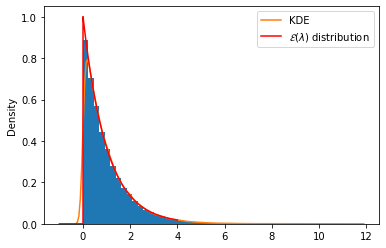

KstestResult(statistic=0.0028901193416019377, pvalue=0.3730739796734507)


In [7]:
liste = [exp_gen(1) for i in range(100000)]

def test_exp(liste):
    plt.hist(liste, density=True, bins=50)
    sns.kdeplot(liste, label="KDE")

    xx = np.linspace(-1, +4, 10000)                                                   
    yy = stats.expon.pdf(xx)
    plt.plot(xx, yy, 'r', label="$\mathcal{E}(\lambda)$ distribution")    
    plt.legend()
    plt.show()

    print(stats.kstest(liste, 'expon'))

test_exp(liste)

### Simulation de la file d'attente

On suppose qu'il y a 0 client à la date 0. On peut servir un seul client à la fois et pendant le temps de service d'un client, les autres clients doivent patienter (et d'autres peuvent arriver).

On note $(A_n)_{n \geq 0}$ la suite des dates d'arrivées des clients. On a en particulier $\forall n \geq 0, A_n \leq A_{n+1}$.

La suite $\tau_n = A_{n+1} - A_n$ est une suite de variables aléatoires iid suivant une loi exponentielle de paramètre $\lambda_1$.

On note $(d_n)_{n \geq 0}$ les durées de service de chaque client. $(d_n)_{n \geq 0}$ est une suite de variables aléatoires iid suivant une loi exponentielle de paramètres $\lambda_2$.

On note enfin $(S_n)_{n \geq 0}$ les dates de début de service de chaque client (c'est à dire sa date de prise en charge). Cette suite vérifie la relation de récurrence suivante :
 - $S_0 = A_0 $ : le premier client est servi dès son arrivée ;
 - $\forall n \geq 1, S_n = \max(S_{n-1} + d_{n-1} , A_n)$ : un client est servi dès son arrivée s'il arrive après la fin de service du client précédent, sinon il doit attendre.

In [8]:
def file_attente(lambda1, lambda2, t, simplification=False, liste_dates_arrivée=None, liste_u=None):
    """
    liste_dates_arrivées et liste_u : seulement pour les méthodes v1 et v2
    """
    if liste_dates_arrivée is None:
        # On simule d'abord toutes les arrivées des clients
        liste_dates_arrivée = [exp_gen(lambda1)]
        temps_nouveau_client = exp_gen(lambda1)
        while liste_dates_arrivée[-1] + temps_nouveau_client <= t:
            liste_dates_arrivée.append(liste_dates_arrivée[-1] + temps_nouveau_client)
            temps_nouveau_client = exp_gen(lambda1)
    
    n_clients = len(liste_dates_arrivée)
    
    if liste_u is None:
        # On simule les temps de service de chaque client
        liste_temps_service = [exp_gen(lambda2) for _ in range(n_clients)]
    else:
        liste_temps_service = [exp_gen(lambda2, liste_u[i]) for i in range(n_clients)]
    
    # On calcule enfin les dates de début et de fin de service de chaque client
    num_client = 0
    date_arrivée = liste_dates_arrivée[num_client]
    temps_service = liste_temps_service[num_client]
    # Le premier client est servi dès son arrivée
    date_début_service = date_arrivée
    date_fin_service = date_début_service + temps_service
    
    liste_dates_début_service = [date_début_service]
    liste_dates_fin_service = [date_fin_service]    
    
    while num_client < n_clients-1:
        num_client += 1
        date_arrivée = liste_dates_arrivée[num_client]
        temps_service = liste_temps_service[num_client]
        
        if date_arrivée >= liste_dates_fin_service[-1]:
            # Si le client arrive après la fin de service du client précédent,
            # il est servi tout de suite
            date_début_service = date_arrivée            
            date_fin_service = date_début_service + temps_service
        else:
            # Sinon le client est servi à l'instant de la fin de service du client précédent
            date_début_service = liste_dates_fin_service[-1]
            date_fin_service = date_début_service + temps_service      

        liste_dates_début_service.append(date_début_service)
        liste_dates_fin_service.append(date_fin_service) 
        
        if simplification and date_fin_service > t:
            break

    l = len(liste_dates_début_service)
    if l < n_clients:
        liste_dates_début_service += [None for i in range(n_clients - l)]
        liste_dates_fin_service += [None for i in range(n_clients - l)]
        
    dico = {"Date arrivée client": liste_dates_arrivée, 
            "Date début service": liste_dates_début_service,
            "Temps service": liste_temps_service,
            "Date fin service": liste_dates_fin_service}
    
    return pd.DataFrame(dico)

In [9]:
data = file_attente(2, 1, 5)
data

,Date arrivée client,Date début service,Temps service,Date fin service
0,0.154414,0.154414,1.257925,1.412338
1,0.155771,1.412338,2.556505,3.968843
2,0.499187,3.968843,0.033295,4.002139
3,0.772110,4.002139,1.251076,5.253215
4,1.605946,5.253215,0.448993,5.702207
5,2.284552,5.702207,0.234424,5.936631
6,2.542624,5.936631,0.221625,6.158256
7,3.871896,6.158256,1.574963,7.733218
8,4.953556,7.733218,0.160115,7.893333


`simplification` permet de réduire les calculs des dates de service en ne calculant que les dates inférieures à t :

In [10]:
file_attente(2, 1, 5, simplification=True)

,Date arrivée client,Date début service,Temps service,Date fin service
0,0.303352,0.303352,0.571330,0.874683
1,0.516971,0.874683,0.269513,1.144195
2,0.886681,1.144195,0.567411,1.711606
3,1.290704,1.711606,0.168189,1.879795
4,2.311966,2.311966,0.740712,3.052678
5,2.516695,3.052678,0.102199,3.154877
6,3.033132,3.154877,0.270057,3.424935
7,3.338391,3.424935,0.684452,4.109387
8,3.708537,4.109387,0.812437,4.921824
9,3.786210,4.921824,0.006392,4.928216


On cherche à présent à calculer le nombre de clients dans la file d'attente à chaque instant.

In [11]:
def search_t(X, t):
    """
    Renvoie i tel que X[i] <= t et X[i+1] >= t
    """
    if t in X:
        return X.index(t)    
    else:
        xt = 0
        while xt <= len(X)-2:
            if X[xt+1] < t:
                xt += 1
            else:
                return xt
        return xt


def nb_client_instant(data, n, t, plot=True, pdf=None):
    """
    Renvoie True si dépassement du seuil n
    False sinon
    """
    X = [0]
    Y = [0]
    
    liste_dates_arrivée = list(data["Date arrivée client"])
    liste_dates_départ = list(data["Date fin service"])
    
    while len(liste_dates_arrivée) > 0 and len(liste_dates_départ) > 0:
        date_arrivée = liste_dates_arrivée[0]
        date_départ = liste_dates_départ[0]
        
        if date_arrivée <= date_départ:
            date = liste_dates_arrivée.pop(0)
            X.append(date)
            Y.append(Y[-1] + 1)
        else:
            date = liste_dates_départ.pop(0)
            X.append(date)
            Y.append(Y[-1] - 1)
    
    while len(liste_dates_arrivée) > 0 :
        date_arrivée = liste_dates_arrivée.pop(0)
        X.append(date_arrivée)
        Y.append(Y[-1] + 1)
        
    while len(liste_dates_départ) > 0 :
        date_départ = liste_dates_départ.pop(0)
        X.append(date_départ)
        Y.append(Y[-1] - 1)
    
    xt = search_t(X,t)

    if plot:
        plt.scatter(X[1:xt+1],Y[1:xt+1])
        plt.scatter(X[xt+1:],Y[xt+1:], c="#C2C2C2")
        for i in range(xt):
            plt.hlines(Y[i], X[i], X[i+1])
            plt.vlines(X[i+1], Y[i], Y[i+1])
        if xt+1 < len(X):
            plt.hlines(Y[xt], X[xt], X[xt+1])
            plt.vlines(X[xt+1], Y[xt], Y[xt+1], color="#C2C2C2")
        for i in range(xt+1, len(X)-1):
            plt.hlines(Y[i], X[i], X[i+1], color="#C2C2C2")
            plt.vlines(X[i+1], Y[i], Y[i+1], color="#C2C2C2")
        plt.axhline(n, c="r", linestyle="--", label="Seuil de clients")
        plt.axvline(t, c="g", label="Date t")
        plt.legend()
        plt.xlabel("Temps")
        plt.ylabel("Nombre de clients")
        if pdf is not None:
            pdf.export()
        plt.show()

    if max(Y[:xt+1]) > n:
        return True
    else:
        return False

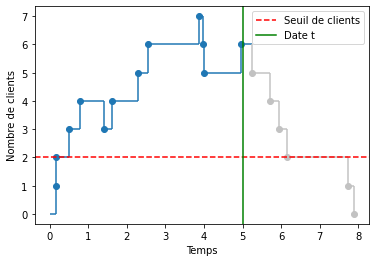

True

In [12]:
nb_client_instant(data, 2, 5)

In [13]:
# # PDF
# nb_client_instant(file_attente(0.2, 0.1, 50), 6, 50, pdf=pdf)

In [14]:
def simulation(lambda1, lambda2, n, t, plot=False, simplification=True, liste_dates_arrivée=None, liste_u=None):
    """
    Combine les fonctions file_attente et nb_client_instant
    """

    data = file_attente(lambda1, lambda2, t, simplification=simplification, liste_dates_arrivée=liste_dates_arrivée, liste_u=liste_u)
    return nb_client_instant(data, n, t, plot=plot)

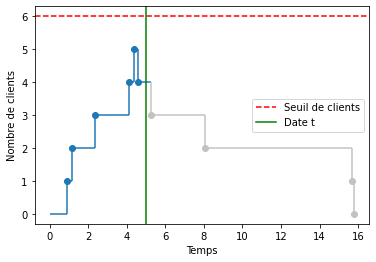

False

In [15]:
simulation(2, 0.5, 6, 5, plot=True, simplification=False)

/home/headless/anaconda3/envs/work/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


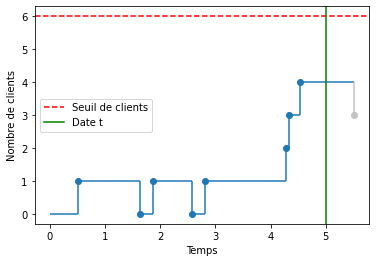

False

In [16]:
simulation(2, 0.5, 6, 5, plot=True, simplification=True)

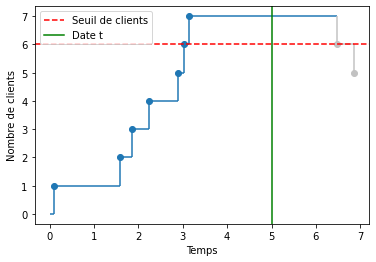

True


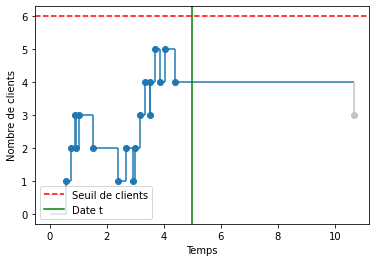

False


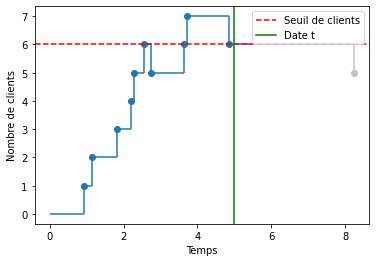

True


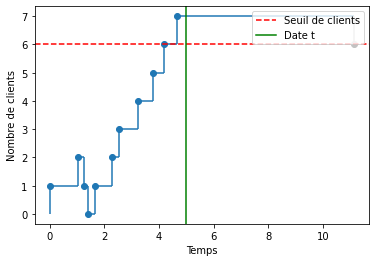

True


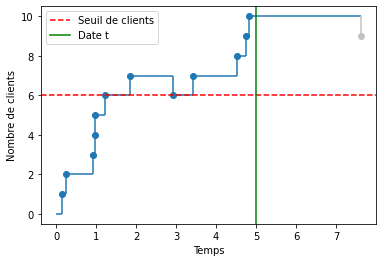

True


In [17]:
for i in range(5):
    print(simulation(2, 0.5, 6, 5, plot=True))

### Estimation de la probabilité

On souhaite calculer la probabilité que le nombre de clients dans la salle d'attente dépasse un certain seuil critique $n$ (entre le temps $0$ et le temps $t$).

Notons $X$ le nombre maximum de clients dans la salle d'attente entre le temps $0$ et le temps $t$. Le code précédent effectue une simulation et renvoie l'indicatrice $\mathbb{1} (X > n)$.

On cherche à estimer $P(X>n) = \mathbb{E}[\mathbb{1} (X > n )]$. On utilise alors la moyenne empirique en réalisant un grand nombre de simulation (noté $N\_simul$) :
$$ \mathbb{E}[\mathbb{1} (X > n)] \approx \sum_{i=1}^{N\_simul} \mathbb{1} (X_i > n) $$




In [18]:
def proba_N_simul_v0(lambda1, lambda2, n, t, N_simul, multiproc=False):
    """
    Proba d'un dépassement du nombre de clients
    """
    def f_(_):
        return simulation(lambda1, lambda2, n, t)
    if multiproc:
        resultat = p_map(f_, [0]*N_simul)
    else:
        resultat = list(map(f_, [0]*N_simul))
    return np.sum(resultat) / len(resultat)

In [19]:
%%time
proba_N_simul_v0(2, 0.5, 6, 5, N_simul=10000, multiproc=False)

CPU times: user 6.96 s, sys: 7.82 ms, total: 6.96 s
Wall time: 6.95 s


0.6826

In [20]:
%%time
if MULTIPROCESSING:
    proba_N_simul_v0(2, 0.5, 6, 5, N_simul=10000, multiproc=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 5.43 s, sys: 879 ms, total: 6.31 s
Wall time: 5.85 s


### Influence des paramètres

On calcule la proba sur de nombreuses combinaisons de paramètres.

In [21]:
def dico_proba(args):
    (lambda1, lambda2, n, t) = args
    return {"lambda1": lambda1,
             "lambda2": lambda2,
             "n": n,
             "t": t,
             "proba": proba_N_simul_v0(lambda1, lambda2, n, t, N_simul=500)}

In [22]:
%%time

LIST_LAMBDA1 = np.linspace(0.1, 10, 10)
LIST_LAMBDA2 = np.linspace(0.1, 10, 10)
LIST_n = np.arange(2, 50, 4)
LIST_t = np.linspace(1, 20, 10)

if LOW_CPU:
    LIST_LAMBDA1 = np.linspace(0.1, 10, 5)
    LIST_LAMBDA2 = np.linspace(0.1, 10, 5)
    LIST_n = np.arange(2, 50, 8)
    LIST_t = np.linspace(1, 20, 5)
if not MULTIPROCESSING:
    LIST_LAMBDA1 = np.linspace(0.1, 10, 4)
    LIST_LAMBDA2 = np.linspace(0.1, 10, 4)
    LIST_n = np.arange(2, 50, 12)
    LIST_t = np.linspace(1, 20, 4)

LISTE_args = list(itertools.product(LIST_LAMBDA1, LIST_LAMBDA2, LIST_n, LIST_t))

if MULTIPROCESSING:
    resul = p_map(dico_proba, LISTE_args)
else:
    resul = []
    for args in tqdm(LISTE_args):
        resul.append(dico_proba(args))

df_resul = pd.DataFrame(resul)

  0%|          | 0/12000 [00:00<?, ?it/s]

CPU times: user 37.2 s, sys: 6.46 s, total: 43.6 s
Wall time: 2min 58s


In [23]:
df_resul

,lambda1,lambda2,n,t,proba
0,0.1,0.1,2,1.000000,0.000
1,0.1,0.1,2,3.111111,0.000
2,0.1,0.1,2,5.222222,0.010
3,0.1,0.1,2,7.333333,0.020
4,0.1,0.1,2,9.444444,0.048
...,...,...,...,...,...
11995,10.0,10.0,46,11.555556,0.006
11996,10.0,10.0,46,13.666667,0.010
11997,10.0,10.0,46,15.777778,0.010
11998,10.0,10.0,46,17.888889,0.026


In [24]:
from ipywidgets import interact
import ipywidgets as widgets

def show_n(lambda1, lambda2, t):
    df_resul_show = df_resul[(df_resul.lambda1==lambda1) & (df_resul.lambda2==lambda2) & (df_resul.t==t)]
    plt.scatter(df_resul_show.n, df_resul_show.proba)
    plt.ylabel("proba")
    plt.xlabel("n")
    plt.show()
    return()

def show_t(lambda1, lambda2, n):
    df_resul_show = df_resul[(df_resul.lambda1==lambda1) & (df_resul.lambda2==lambda2) & (df_resul.n==n)]
    plt.scatter(df_resul_show.t, df_resul_show.proba)
    plt.ylabel("proba")
    plt.xlabel("t")
    plt.show()
    return()

def show_lambda1(lambda2, n, t):
    df_resul_show = df_resul[(df_resul.lambda2==lambda2) & (df_resul.n==n) & (df_resul.t==t)]
    plt.scatter(df_resul_show.lambda1, df_resul_show.proba)
    plt.ylabel("proba")
    plt.xlabel("lambda1")
    plt.show()
    return()

def show_lambda2(lambda1, n, t):
    df_resul_show = df_resul[(df_resul.lambda1==lambda1) & (df_resul.n==n) & (df_resul.t==t)]
    plt.scatter(df_resul_show.lambda2, df_resul_show.proba)
    plt.ylabel("proba")
    plt.xlabel("lambda2")
    plt.show()
    return()

w1 = widgets.SelectionSlider(
    options=[("%.2f"%i,i) for i in LIST_LAMBDA1]
)
w2 = widgets.SelectionSlider(
    options=[("%.2f"%i,i) for i in LIST_LAMBDA2]
)
wt = widgets.SelectionSlider(
    options=[("%.2f"%i,i) for i in LIST_t]
)
wn = widgets.SelectionSlider(
    options=LIST_n
)

interact(show_lambda1, lambda2=w2, n=wn, t=wt)
interact(show_lambda2, lambda1=w1, n=wn, t=wt)
interact(show_n, lambda1=w1, lambda2=w2, t=wt)
interact(show_t, lambda1=w1, lambda2=w2, n=wn)

interactive(children=(SelectionSlider(description='lambda2', options=(('0.10', 0.1), ('1.20', 1.20000000000000…

interactive(children=(SelectionSlider(description='lambda1', options=(('0.10', 0.1), ('1.20', 1.20000000000000…

interactive(children=(SelectionSlider(description='lambda1', options=(('0.10', 0.1), ('1.20', 1.20000000000000…

interactive(children=(SelectionSlider(description='lambda1', options=(('0.10', 0.1), ('1.20', 1.20000000000000…

<function __main__.show_t(lambda1, lambda2, n)>

On trace la proba selon chaque variable en faisant la moyenne sur les autres variables :

Export PDF : img/0_file_attente/var_lambda1.pdf



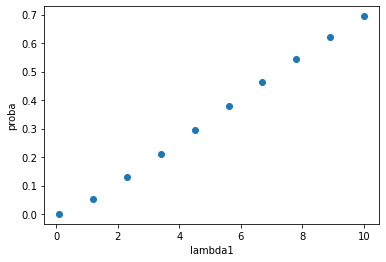

Export PDF : img/0_file_attente/var_lambda2.pdf



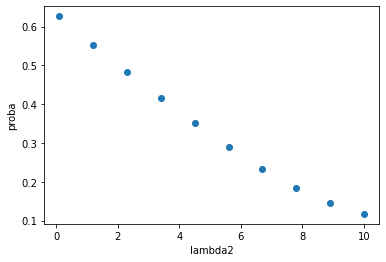

Export PDF : img/0_file_attente/var_n.pdf



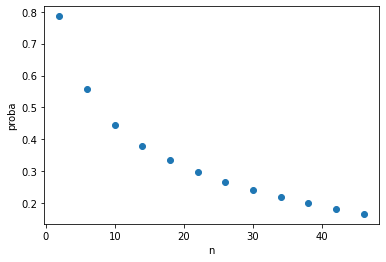

Export PDF : img/0_file_attente/var_t.pdf



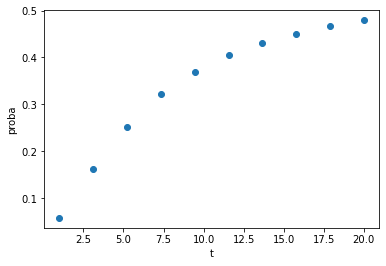

In [25]:
for column in ['lambda1', 'lambda2', 'n', 't']:
    groupby = df_resul.groupby(by=column).mean()
    
    plt.scatter(groupby.index, groupby.proba)
    plt.ylabel("proba")
    plt.xlabel(column)
    pdf.export(f"var_{column}")
    plt.show()

**Conclusion :**

La probabilité que le nombre de clients dans la salle d'attende dépasse un certain seuil critique n (entre le temps 0 et le temps t) est :
- croissante selon $\lambda_1$ ;
- décroissante selon $\lambda_2$ ;
- décroissante selon $N\_simul$ ;
- croissante selon $t$.

## Question 2

### Quasi Monte Carlo

On note $N\_simul$ le nombre de simulations effectuées.

Pour rappel, chaque simulation demande la génération de 2 va : l'une suivant une loi $Exp(\lambda_1)$ et l'autre suivant une loi $Exp(\lambda_2)$. On utilise la méthode de rejet : on simule $U \sim \mathcal{U} [ 0, 1]$ puis on calcule $f(U) = -\frac{1}{\lambda} \log(1-U) \sim Exp(\lambda)$.

Les 2 va doivent cependant être générés un nombre aléatoire (et donc inconnu) de fois pour chaque simulation :
- on génère assez de $Exp(\lambda_1)$ pour avoir des arrivées de clients jusqu'à la date t ;
- on génère ensuite le même nombre de $Exp(\lambda_2)$ pour avoir le temps de service de chaque client.
 
**Explication du problème :**

Dans le cas où l'on aurait qu'un seul couple de va ($Exp(\lambda_1)$,$Exp(\lambda_2)$) à générer pour chaque simulation, on pourrait utiliser une méthode de stratification en dimension 2 : au lieu de générer $N\_simul$ couples d'uniformes sur l'intervalle $[0 ; 1]$, on générerait $N\_simul$ points dans un quadrillage en dimension 2 (chaque ligne et chaque colonne a une aire 1/N) :

![Stratification en dimension 2](img/stratification.jpg)

puis chaque simulation utiliserait les 2 coordonnées d'un point pour définir $U_1$ et $U_2$ puis calculer $f(U_1)$ et $f(U_2)$.

Dans le cas où il faudrait générer $p$ couple de va  ($Exp(\lambda_1)$,$Exp(\lambda_2)$) pour chaque simulation, on pourrait utiliser la méthode de stratification en dimension 2p : on générerait $N\_simul$ points dans un quadrillage en dimension 2p puis chaque simulation utiliserait les 2p coordonnées d'un point pour définir $U_{1,1}, \ldots , U_{1,p}$ et $U_{2,1}, \ldots , U_{2,p}$.

Mais dans notre situation, nous ne connaissons pas la valeur de ce $p$ qui peut varier à chaque simulation ($p$ correspond ici au nombre d'arrivées de clients jusqu'à la date $t$).

**Première idée : stratification locale** 

On utilise la méthode de stratification seulement sur la variable $\lambda_2$ et à l'intérieur de chaque simulation. Pour chaque simulation, après avoir généré un nombre suffisant de $Exp(\lambda_1)$ noté $n_{clients}$, on sait qu'il faut générer $n_{clients}$ va $Exp(\lambda_2)$, on peut donc utiliser une méthode de stratification en dimension 1 avec $n_{clients}$ points pour définir $U_1, \ldots, U_{n_{clients}}$.

**Deuxième idée : stratification globale**

On utilise la méthode de stratification seulement sur la variable $\lambda_2$ mais en réalisant une seule stratification sur les $N\_simul$ simulations. Pour chacune des $N\_simul$ simulations, on génère un nombre suffisant de $Exp(\lambda_1)$, puis on prend le max de ce nombre sur toutes les simulations noté $n_{max\_clients}$. On sait alors qu'il faut générer au maximum $n_{max\_clients}$ va $Exp(\lambda_2)$ dans chaque simulation (quitte à en avoir trop) et on va donc utiliser une stratification en dimension $n_{max\_clients}$ sur laquelle on tire $N\_simul$ points, ce qui permet de définir dans chaque simulation $U_1, \ldots, U_{n_{max\_clients}}$.

In [26]:
def gen_liste_dates_arrivée(lambda1, t):
    # Simule des arrivées de clients jusqu'à la date t
    liste_dates_arrivée = [exp_gen(lambda1)]
    temps_nouveau_client = exp_gen(lambda1)
    while liste_dates_arrivée[-1] + temps_nouveau_client <= t:
        liste_dates_arrivée.append(liste_dates_arrivée[-1] + temps_nouveau_client)
        temps_nouveau_client = exp_gen(lambda1)
    return liste_dates_arrivée

26
Export PDF : img/0_file_attente/density.pdf



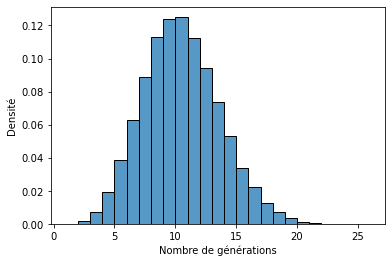

In [27]:
liste = [len(gen_liste_dates_arrivée(0.2,50)) for _ in range(100000)]
print(max(liste))
sns.histplot(liste,binwidth=1, stat="density")
plt.xlabel("Nombre de générations")
plt.ylabel("Densité")
pdf.export("density")
plt.show()

#### LHS

Nous utiliserons la méthode Latin Hypercube sampling (LHS) du module smt.

(50, 2)


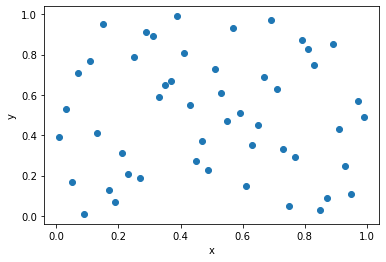

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from smt.sampling_methods import LHS

xlimits = np.array([[0.0, 1.0], [0.0, 1.0]])
sampling = LHS(xlimits=xlimits)

num = 50
x = sampling(num)

print(x.shape)

plt.plot(x[:, 0], x[:, 1], "o")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

#### Idée v1

In [29]:
def proba_N_simul_v1(lambda1, lambda2, n, t, N_simul, multiproc=False):
    """
    Proba d'un dépassement du nombre de clients avec stratification locale (dans chaque simulation) sur lambda2
    Dans chaque simulation, on fait un stratification en dimension 1 avec n_clients points pour générer les n_clients Exp(lambda2)
    """
    N_listes_dates_arrivée = [gen_liste_dates_arrivée(lambda1, t) for _ in range(N_simul)]
    
    N_listes_u = []
    for i in range(N_simul):
        n_clients = len(N_listes_dates_arrivée[i])   
        sampling = sampling = LHS(xlimits=np.array([[0.0, 1.0]]))
        liste_u = sampling(n_clients).ravel()
        N_listes_u.append(liste_u)
    
    def f(i):
        return simulation(lambda1, lambda2, n, t, liste_dates_arrivée=N_listes_dates_arrivée[i], liste_u=N_listes_u[i])
    
    def f_multi(liste_dates_arrivée, liste_u):
        return simulation(lambda1, lambda2, n, t, liste_dates_arrivée=liste_dates_arrivée, liste_u=liste_u)
    
    if multiproc:
        resultat = p_map(f_multi, N_listes_dates_arrivée, N_listes_u)
    else:
        resultat = list(map(f, range(N_simul)))
    return np.sum(resultat) / len(resultat)

In [30]:
%%time
proba_N_simul_v1(2, 0.5, 6, 5, N_simul=10000, multiproc=False)

CPU times: user 10.1 s, sys: 63.8 ms, total: 10.1 s
Wall time: 10.1 s


0.6907

In [31]:
%%time
if MULTIPROCESSING:
    proba_N_simul_v1(2, 0.5, 6, 5, N_simul=10000, multiproc=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 11.1 s, sys: 849 ms, total: 11.9 s
Wall time: 11.4 s


#### Idée v2

In [32]:
def proba_N_simul_v2(lambda1, lambda2, n, t, N_simul, multiproc=False):
    """
    Proba d'un dépassement du nombre de clients avec stratification globale sur lambda2
    On fait une seule stratification en dimension n_max_clients (majorant du nombre d'arrivées sur les N simulations) 
    avec N points pour ensuite générer dans chaque simulation n_max_clients Exp(lambda2)
    """
    N_listes_dates_arrivée = [gen_liste_dates_arrivée(lambda1, t) for _ in range(N_simul)]
    
    n_max_clients = max([len(elem) for elem in N_listes_dates_arrivée])
    
    sampling = LHS(xlimits=np.array([[0.0, 1.0]]*n_max_clients))
    N_listes_u = sampling(N_simul)
    
    def f(i):
        return simulation(lambda1, lambda2, n, t, liste_dates_arrivée=N_listes_dates_arrivée[i], liste_u=N_listes_u[i])
    
    def f_multi(liste_dates_arrivée, liste_u):
        return simulation(lambda1, lambda2, n, t, liste_dates_arrivée=liste_dates_arrivée, liste_u=liste_u)
    
    if multiproc:
        resultat = p_map(f_multi, N_listes_dates_arrivée, N_listes_u)
    else:
        resultat = list(map(f, range(N_simul)))
    return np.sum(resultat) / len(resultat)

In [33]:
%%time
proba_N_simul_v2(2, 0.5, 6, 5, N_simul=10000, multiproc=False)

CPU times: user 6.72 s, sys: 35.2 ms, total: 6.76 s
Wall time: 6.75 s


0.6713

In [34]:
%%time
if MULTIPROCESSING:
    proba_N_simul_v2(2, 0.5, 6, 5, N_simul=10000, multiproc=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 8.38 s, sys: 851 ms, total: 9.23 s
Wall time: 8.65 s


#### Idée v3

On calcule un "majorant" empirique du nombre de générations de $Exp(\lambda_1)$ nécessaires pour atteindre le temps $t$ dans une majorité des cas, puis on réalise une stratification globale sur les variables $\lambda_1$ et $\lambda_2$. 

Notons $M$ ce "majorant" empirique qui dépend de $\lambda_1$ et de $t$. On sait alors qu'il faut générer au maximum $M$ va $Exp(\lambda_1)$ et $Exp(\lambda_2)$ dans chaque simulation. On utilise donc une stratification en dimension $2M$ sur laquelle on tire $N\_simul$ points.

On recherche ainsi le plus petit $M$ qui vérifie :
$$P\left( \sum_{i=1}^{M} W_i \geq t \right) \geq s \quad \text{avec} \ W_1, \ldots, W_M \sim Exp(\lambda_1)$$
et avec un seuil $s$ arbitrairement proche de $1$. Cela nous assure que lorsque nous générerons $M$ arrivées de clients, nous atteindrons dans une grande majorité des cas le temps $t$.

Cela revient à déterminer $M$ tel que 
$$P\left(\Gamma(M, \lambda_1) > t\right) \geq s$$
$$ 1 - P(\Gamma(M, \lambda_1) < t) \geq s$$
$$ F_{\Gamma(M, \lambda_1)}(t) \leq 1 - s$$

Comme $M$ est entier, la loi Gamma correspond à une loi d'Erlang et sa fonction de répartition est donnée par la formule suivante :
$$ F_{\Gamma(M, \lambda)}(t) = 1 - \sum_{i=0}^{M-1} e^{-\lambda t} \frac{(\lambda t)^i}{i!}$$

Cela revient à déterminer $M$ tel que
$$ \sum_{i=0}^{M-1} e^{-\lambda t} \frac{(\lambda t)^i}{i!} \geq s $$

L'inconvénient de cette méthode est une baisse de la précision de l'estimation de la proba, il se peut en effet que dans certaines simulations, on "oublie" des clients à cause de la majoration du nombre de générations d'arrivées de clients.

In [35]:
def majorant_test(lambda1, t, seuil=0.9999):
    """
    Détermine le plus petit m tel quel la somme de m Exp(lambda1) dépasse t avec une proba supérieure à seuil.
    Utilisation de scipy pour test.
    """
    m = 0
    while True:
        m += 1
        if stats.gamma.cdf(t, m, scale=1/lambda1) <= 1-seuil:
            return m

In [36]:
majorant_test(0.2, 50),majorant_test(0.1, 10),majorant_test(5, 100)

(25, 7, 586)

In [37]:
def factorielle(n):
    if n == 0:
        return 1
    else:
        return n  * factorielle(n-1)

def majorant(lambda1, t, seuil=0.9999):
    """
    Détermine le plus petit m tel quel la somme de m Exp(lambda1) dépasse t avec une proba supérieure à seuil.
    N'utilise pas scipy.
    """
    m = 0
    somme = 0
    while True:
        a = exp(-lambda1 * t)
        b = ((lambda1 * t)**m)
        c = factorielle(m)
        somme += a * (b / c)  # /!\ ordre très important
        m += 1
        if somme >= seuil:
            return m

In [38]:
majorant(0.2, 50),majorant(0.1, 10),majorant(5, 100)

(25, 7, 586)

Test avec $\lambda_1 = 0.2$ et $t=50$.

27


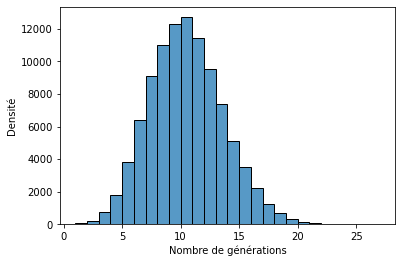

In [39]:
liste = [len(gen_liste_dates_arrivée(0.2,50)) for _ in range(100000)]
print(max(liste))
sns.histplot(liste,binwidth=1)
plt.xlabel("Nombre de générations")
plt.ylabel("Densité")
plt.show()

In [40]:
majorant(0.2, 50)

25

In [41]:
def gen_liste_dates_arrivée_u(lambda1, liste_u):
    # Simule des arrivées de client à partir de la liste des u
    liste_dates_arrivée = [exp_gen(lambda1, liste_u[0])]
    for i in range(1, len(liste_u)):
        liste_dates_arrivée.append(liste_dates_arrivée[-1] + exp_gen(lambda1, liste_u[i]))
    return liste_dates_arrivée

In [42]:
def proba_N_simul_v3(lambda1, lambda2, n, t, N_simul, multiproc=False):
    """
    Proba d'un dépassement du nombre de clients avec stratification globale sur lambda1 et lambda2
    On fait une seule stratification en dimension 2M (majorant "empirique" du nombre d'arrivées) 
    avec N points pour ensuite générer dans chaque simulation M Exp(lambda1) et M Exp(lambda2)
    """
    M = majorant(lambda1, t)
    
    sampling = LHS(xlimits=np.array([[0.0, 1.0]]*(2*M)))
    N_listes_uall = sampling(N_simul)
    N_listes_u1 = [elem[:M] for elem in N_listes_uall]
    N_listes_u2 = [elem[M:] for elem in N_listes_uall]

    N_listes_dates_arrivée = [gen_liste_dates_arrivée_u(lambda1, liste_u) for liste_u in N_listes_u1]
    
    def f(i):
        return simulation(lambda1, lambda2, n, t, liste_dates_arrivée=N_listes_dates_arrivée[i], liste_u=N_listes_u2[i])
    
    def f_multi(liste_dates_arrivée, liste_u):
        return simulation(lambda1, lambda2, n, t, liste_dates_arrivée=liste_dates_arrivée, liste_u=liste_u)
    
    if multiproc:
        resultat = p_map(f_multi, N_listes_dates_arrivée, N_listes_u2)
    else:
        resultat = list(map(f, range(N_simul)))
    return np.sum(resultat) / len(resultat)

In [43]:
%%time
proba_N_simul_v3(2, 0.5, 6, 5, N_simul=10000, multiproc=False)

CPU times: user 7.61 s, sys: 28.8 ms, total: 7.64 s
Wall time: 7.64 s


0.6752

In [44]:
%%time
proba_N_simul_v3(2, 0.5, 6, 5, N_simul=10000, multiproc=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 8.59 s, sys: 796 ms, total: 9.39 s
Wall time: 8.92 s


0.6775

### Comparaison des performances

/home/headless/anaconda3/envs/work/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


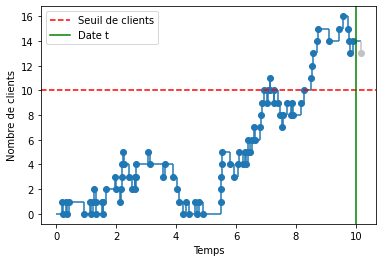

True

In [45]:
simulation(5,5,10,10, plot=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Export PDF : img/0_file_attente/4versions_10.pdf



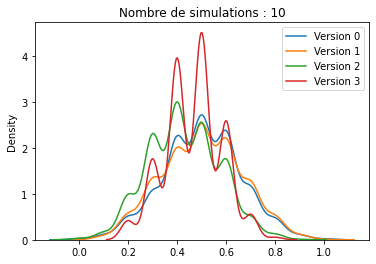

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Export PDF : img/0_file_attente/4versions_20.pdf



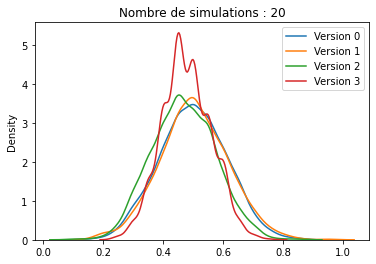

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Export PDF : img/0_file_attente/4versions_50.pdf



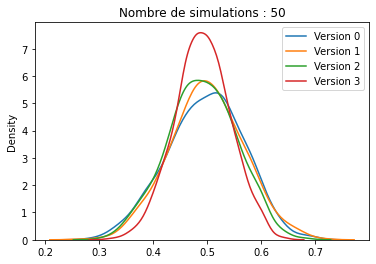

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Export PDF : img/0_file_attente/4versions_100.pdf



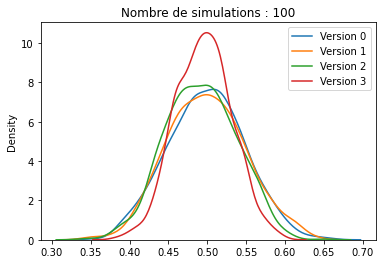

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Export PDF : img/0_file_attente/4versions_250.pdf



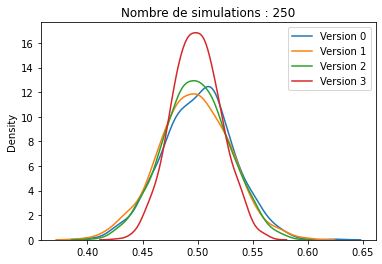

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Export PDF : img/0_file_attente/4versions_500.pdf



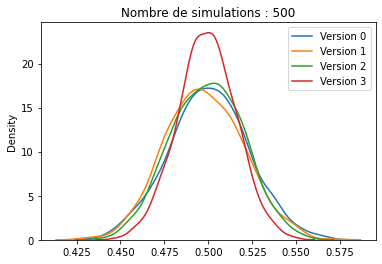

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Export PDF : img/0_file_attente/4versions_750.pdf



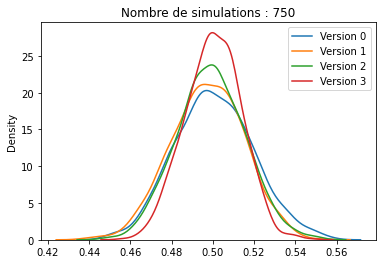

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Export PDF : img/0_file_attente/4versions_1000.pdf



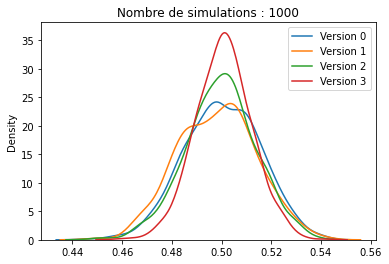

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Export PDF : img/0_file_attente/4versions_2000.pdf



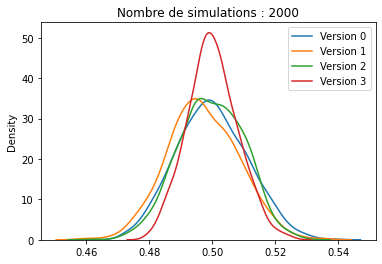

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Export PDF : img/0_file_attente/4versions_5000.pdf



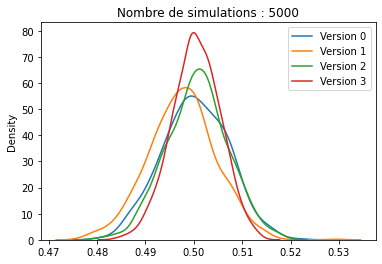

CPU times: user 1min 31s, sys: 29.8 s, total: 2min 1s
Wall time: 21min 48s


In [46]:
%%time
def f_v0(N_simul):
    return proba_N_simul_v0(5,5,10,10, N_simul=N_simul)
def f_v1(N_simul):
    return proba_N_simul_v1(5,5,10,10, N_simul=N_simul)
def f_v2(N_simul):
    return proba_N_simul_v2(5,5,10,10, N_simul=N_simul)
def f_v3(N_simul):
    return proba_N_simul_v3(5,5,10,10, N_simul=N_simul)

scores_dico = {}
calculs_dico = {}
df_scores_dico = {}

liste_N_simul = [10, 20, 50, 100, 250, 500, 750, 1000, 2000, 5000]
nb = 1000  # Nombre de calculs de la proba pour avoir la variance
if LOW_CPU:
    liste_N_simul = [10, 20, 50, 100, 250, 500]
    nb = 200
if not MULTIPROCESSING:
    nb = 100

for label in ["Version 0", "Version 1", "Version 2", "Version 3"]:
    scores_dico[label] = []
    calculs_dico[label] = []

for N_simul in liste_N_simul:
    for (f_vi, label) in [(f_v0, "Version 0"), (f_v1, "Version 1"), (f_v2, "Version 2"), (f_v3, "Version 3")]:    
        if MULTIPROCESSING:
            calculs = p_map(f_vi, [N_simul]*nb)
        else:        
            calculs = []
            for _ in trange(nb):
                calculs.append(f_vi(N_simul))

        calculs_dico[label].append(calculs)
        sns.kdeplot(calculs, label=label)
        scores_dico[label].append({"N_simul":N_simul,
                       "mean": np.mean(calculs),
                       "variance": np.var(calculs)})

    plt.legend()    
    plt.title(f"Nombre de simulations : {N_simul}")
    pdf.export(f"4versions_{N_simul}")
    plt.show()

for label, scores in scores_dico.items():
    df_scores = pd.DataFrame(scores)
    df_scores_dico[label] = df_scores

Export PDF : img/0_file_attente/boxplot_Version 0.pdf



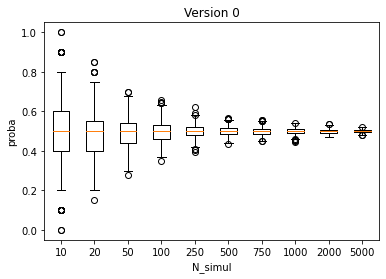

Export PDF : img/0_file_attente/boxplot_Version 1.pdf



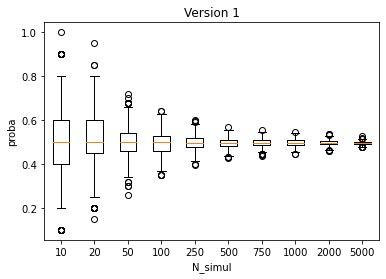

Export PDF : img/0_file_attente/boxplot_Version 2.pdf



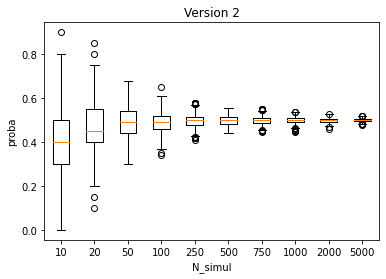

Export PDF : img/0_file_attente/boxplot_Version 3.pdf



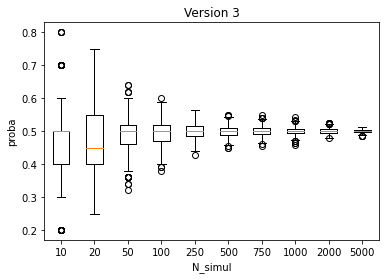

In [47]:
for label, calculs in calculs_dico.items():
    plt.boxplot(calculs)
    plt.xlabel("N_simul")
    plt.ylabel("proba")
    plt.xticks([i for i in range(1,len(liste_N_simul)+1)], liste_N_simul)
    pdf.export(f"boxplot_{label}")
    plt.title(label)
    plt.show()

Export PDF : img/0_file_attente/variance.pdf



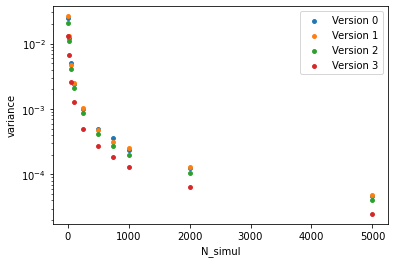

In [48]:
for label, df_scores in df_scores_dico.items():
    plt.scatter(df_scores.N_simul, df_scores.variance, label=label, s=15)
plt.xlabel("N_simul")
plt.ylabel("variance")
plt.yscale('log')
plt.legend()
pdf.export(f"variance")
plt.show()

Version 0
y = ax + b
a   =  -1.001
b   =  -1.388
r^2 = 0.99960
Version 1
y = ax + b
a   =  -1.007
b   =  -1.349
r^2 = 0.99961
Version 2
y = ax + b
a   =  -1.005
b   =  -1.542
r^2 = 0.99981
Version 3
y = ax + b
a   =  -1.006
b   =  -2.009
r^2 = 0.99974
Export PDF : img/0_file_attente/regression.pdf



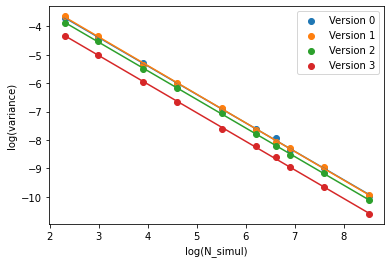

In [49]:
for label, df_scores in df_scores_dico.items():
    X = list(np.log(df_scores.N_simul))
    Y = list(np.log(df_scores.variance))

    a, b, r, p_value, std_err = linregress(X, Y)
    
    print(label)
    print("y = ax + b")
    print("a   ={:8.3f}\nb   ={:8.3f}\nr^2 ={:8.5f}".format(a, b, r**2))

    plt.scatter(X, Y, label=label)

    plt.plot( # droite de regression
        [X[0], X[-1]],                  # valeurs de x
        [a * X[0] + b, a * X[-1] + b],  # valeurs de y
        "-",                           # couleur rouge avec un trait continu
        # label=f"Régression {label}",  # legende
    )

plt.xlabel("log(N_simul)")
plt.ylabel("log(variance)")
plt.legend()
pdf.export("regression")
plt.show()

$\log(variance) = a  log(n) + b$ est équivalent à $ variance = \exp(b) n^{a} $

La régression de la version 0 donne $a=-1$ donc la variance diminue à une vitesse de $\frac{1}{N\_simul}$ ce qui correspond bien à la méthode de Monte Carlo standard.

Les autres méthodes présentent aussi vitesse de décroissance de la variance en $\frac{1}{N\_simul}$.

In [50]:
best = []
for label, df_scores in df_scores_dico.items():
    best_score = dict(df_scores.iloc[-1])
    best_score['Méthode'] = label
    best.append(best_score)
pd.DataFrame(best).set_index('Méthode')

,N_simul,mean,variance
Méthode,,,
Version 0,5000.0,0.500261,0.000047
Version 1,5000.0,0.497587,0.000049
Version 2,5000.0,0.500680,0.000040
Version 3,5000.0,0.500436,0.000025


Les moyennes sont semblables.

In [51]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:26:04
